In [39]:

import numpy as np
import pandas as pd
import vectorbt as vbt

In [40]:
split_kwargs = dict(
    n=30, 
    window_len=365 * 2, 
    set_lens=(180,), 
    left_to_right=False
)  # 30 windows, each 2 years long, reserve 180 days for test
pf_kwargs = dict(
    direction='both',  # long and short
    freq='d'
)
windows = np.arange(10, 50)

In [41]:
price = vbt.YFData.download('TQQQ').get('Close')


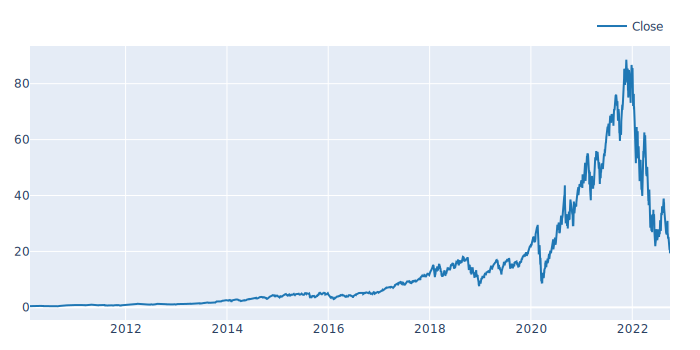

In [42]:
price.vbt.plot().show_svg()


In [43]:
def roll_in_and_out_samples(price, **kwargs):
    return price.vbt.rolling_split(**kwargs)

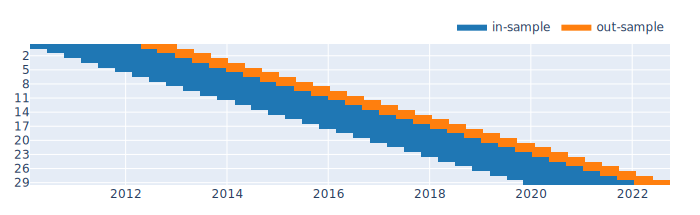

In [44]:
roll_in_and_out_samples(price, **split_kwargs, plot=True, trace_names=['in-sample', 'out-sample']).show_svg()


In [45]:
(in_price, in_indexes), (out_price, out_indexes) = roll_in_and_out_samples(price, **split_kwargs)

print(in_price.shape, len(in_indexes))  # in-sample
print(out_price.shape, len(out_indexes))  # out-sample

(550, 30) 30
(180, 30) 30


In [46]:
def simulate_holding(price, **kwargs):
    pf = vbt.Portfolio.from_holding(price, **kwargs)
    return pf.sharpe_ratio()

In [47]:
in_hold_sharpe = simulate_holding(in_price, **pf_kwargs)

print(in_hold_sharpe)

split_idx
0     1.292969
1     1.198677
2     0.927726
3     0.640757
4     1.115918
5     1.587914
6     1.454048
7     2.001163
8     1.929058
9     2.269372
10    1.743879
11    1.268225
12    0.671050
13    0.872851
14    0.782877
15    0.932553
16    1.202724
17    1.452214
18    1.831442
19    2.326225
20    1.005580
21    1.113889
22    1.030479
23    1.104290
24    0.704107
25    0.989264
26    1.350514
27    1.348682
28    1.504902
29    1.484911
Name: sharpe_ratio, dtype: float64


In [48]:
def simulate_all_params(price, windows, **kwargs):
    fast_ma, slow_ma = vbt.MA.run_combs(price, windows, r=2, short_names=['fast', 'slow'])
    entries = fast_ma.ma_crossed_above(slow_ma)
    exits = fast_ma.ma_crossed_below(slow_ma)
    pf = vbt.Portfolio.from_signals(price, entries, exits, **kwargs)
    return pf.sharpe_ratio()

In [49]:
# Simulate all params for in-sample ranges
in_sharpe = simulate_all_params(in_price, windows, **pf_kwargs)

print(in_sharpe)

fast_window  slow_window  split_idx
10           11           0           -0.409212
                          1            0.019522
                          2            0.103225
                          3            0.198984
                          4            0.179493
                                         ...   
48           49           25          -0.666540
                          26          -0.705868
                          27          -0.739109
                          28          -0.805783
                          29          -0.806083
Name: sharpe_ratio, Length: 23400, dtype: float64


In [50]:
def get_best_index(performance, higher_better=True):
    if higher_better:
        return performance[performance.groupby('split_idx').idxmax()].index
    return performance[performance.groupby('split_idx').idxmin()].index

In [51]:
in_best_index = get_best_index(in_sharpe)

print(in_best_index)

MultiIndex([(44, 49,  0),
            (15, 21,  1),
            (15, 21,  2),
            (15, 21,  3),
            (28, 45,  4),
            (21, 32,  5),
            (20, 39,  6),
            (20, 39,  7),
            (23, 24,  8),
            (23, 24,  9),
            (22, 24, 10),
            (19, 28, 11),
            (19, 28, 12),
            (19, 21, 13),
            (39, 45, 14),
            (40, 44, 15),
            (40, 45, 16),
            (39, 47, 17),
            (41, 42, 18),
            (33, 47, 19),
            (33, 47, 20),
            (32, 45, 21),
            (34, 40, 22),
            (33, 47, 23),
            (16, 34, 24),
            (11, 14, 25),
            (11, 14, 26),
            (10, 16, 27),
            (12, 19, 28),
            (11, 14, 29)],
           names=['fast_window', 'slow_window', 'split_idx'])


In [52]:
def get_best_params(best_index, level_name):
    return best_index.get_level_values(level_name).to_numpy()

In [53]:
in_best_fast_windows = get_best_params(in_best_index, 'fast_window')
in_best_slow_windows = get_best_params(in_best_index, 'slow_window')
in_best_window_pairs = np.array(list(zip(in_best_fast_windows, in_best_slow_windows)))

print(in_best_window_pairs)

[[44 49]
 [15 21]
 [15 21]
 [15 21]
 [28 45]
 [21 32]
 [20 39]
 [20 39]
 [23 24]
 [23 24]
 [22 24]
 [19 28]
 [19 28]
 [19 21]
 [39 45]
 [40 44]
 [40 45]
 [39 47]
 [41 42]
 [33 47]
 [33 47]
 [32 45]
 [34 40]
 [33 47]
 [16 34]
 [11 14]
 [11 14]
 [10 16]
 [12 19]
 [11 14]]


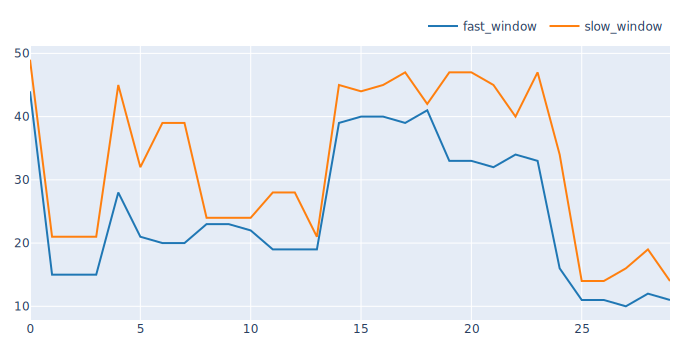

In [54]:
pd.DataFrame(in_best_window_pairs, columns=['fast_window', 'slow_window']).vbt.plot().show_svg()


In [56]:
out_hold_sharpe = simulate_holding(out_price, **pf_kwargs)

print(out_hold_sharpe)

split_idx
0     0.186010
1     0.934193
2     2.146763
3     3.557348
4     1.814284
5     1.925233
6     2.414473
7     1.079427
8     0.216364
9    -0.461019
10    0.248038
11    0.245964
12    1.971905
13    2.599415
14    3.426194
15    2.864984
16    1.425409
17    1.255722
18   -0.115401
19   -0.148160
20    1.690709
21    1.767119
22    1.036640
23    1.121516
24    2.768556
25    1.723006
26    1.383086
27    0.846405
28   -1.034118
29   -1.665737
Name: sharpe_ratio, dtype: float64


In [58]:
# Simulate all params for out-sample ranges
out_sharpe = simulate_all_params(out_price, windows, **pf_kwargs)

print(out_sharpe)

fast_window  slow_window  split_idx
10           11           0            2.001048
                          1            2.279468
                          2            0.134959
                          3           -1.437504
                          4           -1.585578
                                         ...   
48           49           25          -0.491739
                          26          -1.771791
                          27           0.384436
                          28           1.420510
                          29          -0.015956
Name: sharpe_ratio, Length: 23400, dtype: float64


In [60]:
def simulate_best_params(price, best_fast_windows, best_slow_windows, **kwargs):
    fast_ma = vbt.MA.run(price, window=best_fast_windows, per_column=True)
    slow_ma = vbt.MA.run(price, window=best_slow_windows, per_column=True)
    entries = fast_ma.ma_crossed_above(slow_ma)
    exits = fast_ma.ma_crossed_below(slow_ma)
    pf = vbt.Portfolio.from_signals(price, entries, exits, **kwargs)
    return pf.sharpe_ratio()

In [62]:
# Use best params from in-sample ranges and simulate them for out-sample ranges
out_test_sharpe = simulate_best_params(out_price, in_best_fast_windows, in_best_slow_windows, **pf_kwargs)

print(out_test_sharpe)

ma_window  ma_window  split_idx
44         49         0            0.304397
15         21         1            0.681639
                      2           -1.352656
                      3            0.243181
28         45         4           -0.595302
21         32         5            1.883719
20         39         6           -1.247564
                      7           -2.044494
23         24         8            0.327308
                      9            0.358296
22         24         10           1.613390
19         28         11          -2.287407
                      12          -0.299869
           21         13           2.598852
39         45         14           0.367387
40         44         15           2.730662
           45         16           1.747306
39         47         17           1.704856
41         42         18           0.379090
33         47         19           0.780620
                      20          -2.394943
32         45         21           1.803453


In [64]:
cv_results_df = pd.DataFrame({
    'in_sample_hold': in_hold_sharpe.values,
    'in_sample_median': in_sharpe.groupby('split_idx').median().values,
    'in_sample_best': in_sharpe[in_best_index].values,
    'out_sample_hold': out_hold_sharpe.values,
    'out_sample_median': out_sharpe.groupby('split_idx').median().values,
    'out_sample_test': out_test_sharpe.values
})

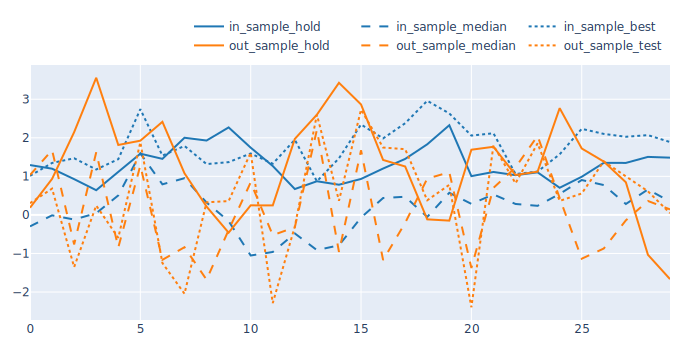

In [66]:
color_schema = vbt.settings['plotting']['color_schema']

cv_results_df.vbt.plot(
    trace_kwargs=[
        dict(line_color=color_schema['blue']),
        dict(line_color=color_schema['blue'], line_dash='dash'),
        dict(line_color=color_schema['blue'], line_dash='dot'),
        dict(line_color=color_schema['orange']),
        dict(line_color=color_schema['orange'], line_dash='dash'),
        dict(line_color=color_schema['orange'], line_dash='dot')
    ]
).show_svg()